# Parallelisation of the incident field calculation

The incident field represents the acoustic pressure generated by a source radiating in a medium in absence of scatterers. To compute the total presure field, OptimUS calculates the incident pressure and its normal gradient at vertices on the domain grids representing the scatterers. For visualisation of the pressure field, OptimUS then requires the calculation of the incident pressure at observer locations in the exterior domain. These operations can be CPU intensive at high $ka$ values, where $k$ is the wavenumber and $a$ relates to the source dimensions. In OptimUS, two Python libraries are available to parallelise these operations: the Numba library (default) and the Multiprocessing library. Here, we show scenarios where either library may be used.

## Import the OptimUS library

Load the OptimUS library.

In [2]:
import optimus

## Define a low $ka$ bowl transducer as acoustic source

The OptimUS library provides different predefined wave fields, among which is a spherical section bowl source radiating in 2*pi space. The bowl requires the frequency, outer radius and radius of curvature to be specified and, optionally, the source axis, the velocity amplitude and its location, which is in this case at [0, 0, 0]. All units are in the SI system. We initially set the velocity of the bowl source to 0.04 m/s and compute the incident field. Here, we will specify a source with low $ka$ with an excitation frequency of 5 kHz.

In [3]:
frequency = 5e3
radius_of_curvature = 0.064
radius = radius_of_curvature / 2
location = (0, 0, 0)
velocity = 0.04
source = optimus.source.create_bowl(frequency, outer_radius=radius, radius_of_curvature=radius_of_curvature, 
                                    location=location, source_axis=(1, 0, 0), velocity=velocity)

## Specify the physical settings for the simulation

Let us consider acoustic waves are propagating in an unbounded region of non-attenuating water.

In [4]:
material_ext = optimus.material.create_material(name='water-no-attenuation',
                                                density=1000,
                                                speed_of_sound=1500)

## Generate a plotting grid in the exterior medium

Here we define a plotting grid in the $xy$ Cartesian plane.

In [5]:
grid_resolution = (241, 141)
grid_lims = (0.0, 0.12, -0.035, 0.035)
points = optimus.utils.mesh.create_grid_points(resolution=grid_resolution,
                                                   plane_axes=(0,1),
                                                   plane_offset=0,
                                                   bounding_box=grid_lims,
                                                   mode="numpy")

## Calculate the incident field at the plotting grid locations

We import transducer_field from optimus.source.transducers and we calculation the incident field at the plotting grid points. We check that the default Numba library is used to parallelise this operation by setting verbose=True in transducer_field. It is preferable to use the Numba option for smaller problem sizes and when running jobs on computers with a small number of CPU.

In [6]:
%%time
from optimus.source.transducers import transducer_field
inc_field = transducer_field(source, material_ext, points[0], verbose=True)

Actual transducer area (m^2): 0.00344796043050
Approximated transducer area (m^2): 0.00812713484786
Number of point sources in transducer: 3
Parallelisation library is: numba
CPU times: user 3.68 s, sys: 22.9 ms, total: 3.7 s
Wall time: 3.62 s


## Plot the incident acoustic pressure field

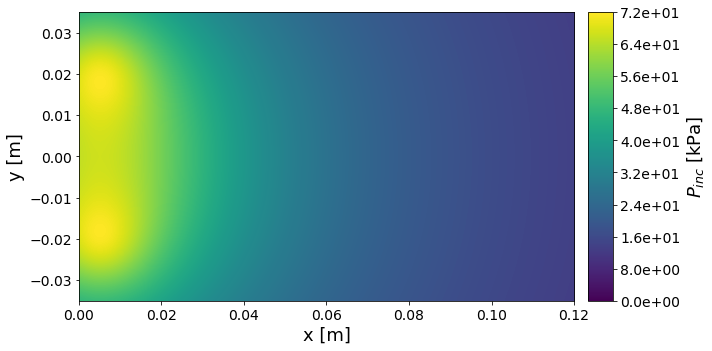

In [7]:
import numpy as np
p_inc_plt = np.abs(inc_field.pressure.reshape(grid_resolution)).T / 1e3
%matplotlib inline
fig = optimus.postprocess.plot.surface_plot(p_inc_plt,
                                      axes_lims=grid_lims,
                                      axes_labels=["x [m]","y [m]"],
                                      colormap="viridis",
                                      colormap_lims=[0,np.max(abs(p_inc_plt))],
                                      colorbar_unit="$P_{inc}$ [kPa]",
                                      domains_edges=None)

## Define a high $ka$ bowl transducer as acoustic source

We now define a high $ka$ bowl transducer by keeping the above dimensions the same and increasing the frequency 500 kHz.

In [8]:
frequency = 500e3
radius_of_curvature = 0.064
radius = radius_of_curvature / 2
location = (0, 0, 0)
velocity = 0.04
source = optimus.source.create_bowl(frequency, outer_radius=radius, radius_of_curvature=radius_of_curvature, 
                                    location=location, source_axis=(1, 0, 0), velocity=velocity)

## Calculate the incident field at the plotting grid locations

We can try the different parallelization methodologies implemented in OptimUS and compare them:

In [12]:
optimus.global_parameters.incident_field_parallelisation.parallelisation_method = "multiprocessing"

In [13]:
%%time
inc_field_2 = transducer_field(source, material_ext, points[0], verbose=True)

Actual transducer area (m^2): 0.00344796043050
Approximated transducer area (m^2): 0.00344772584783
Number of point sources in transducer: 13789
Parallelisation library is: multiprocessing
Parallelisation of incident field calculation over observer locations
CPU times: user 188 ms, sys: 127 ms, total: 314 ms
Wall time: 57.4 s


In [14]:
optimus.global_parameters.incident_field_parallelisation.parallelisation_method = "numba"

In [15]:
%%time
inc_field_3 = transducer_field(source, material_ext, points[0], verbose=True)

Actual transducer area (m^2): 0.00344796043050
Approximated transducer area (m^2): 0.00344772584783
Number of point sources in transducer: 13789
Parallelisation library is: numba
CPU times: user 26min 21s, sys: 695 ms, total: 26min 21s
Wall time: 3min 24s


In [16]:
optimus.global_parameters.incident_field_parallelisation.parallelisation_method = "multiprocessing_shared"

In [17]:
%%time
inc_field_4 = transducer_field(source, material_ext, points[0], verbose=True)

Actual transducer area (m^2): 0.00344796043050
Approximated transducer area (m^2): 0.00344772584783
Number of point sources in transducer: 13789
Parallelisation library is: multiprocessing (shared)
Parallelisation of incident field calculation over observer locations
CPU times: user 174 ms, sys: 80 ms, total: 254 ms
Wall time: 56.9 s


It is worth mentioning that the Wall time corresponds to the total execution time and that, for the Multiprocessing cases, the CPU times correspond only to the times of the main process and not to the other workers. On the other hand, in the Numba case we can see that the CPU times correspond to the sum of all the parallel jobs performed by the same core.

We can notice a clear difference between the execution times of Multiprocessing and Numba. In general, it is preferable to use the Multiprocessing option for larger problem sizes and when running jobs on computers with a large number of CPUs. In addition, both multiprocessing implementations are very similar, this is because the latter is only concerned that both input and output arrays are shared between workers, which considerably decreases the amount of RAM used by the execution.

Finally, we can check if all the answers match with a certain tolerance:

In [29]:
print(np.allclose(inc_field_2.pressure, inc_field_3.pressure))
print(np.allclose(inc_field_3.pressure, inc_field_4.pressure))

True
True


Verifying that the answers coincide. As a comment, it is normal to observe minor differences between the answers, this is due to small rounding errors that occur when changing the order of the sum of floating point numbers.

## Plot the incident acoustic pressure field

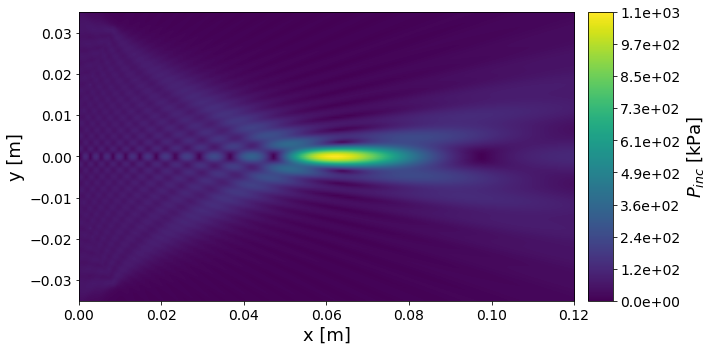

In [30]:
p_inc_plt_2 = np.abs(inc_field_2.pressure.reshape(grid_resolution)).T / 1e3
fig = optimus.postprocess.plot.surface_plot(p_inc_plt_2,
                                      axes_lims=grid_lims,
                                      axes_labels=["x [m]","y [m]"],
                                      colormap="viridis",
                                      colormap_lims=[0,np.max(abs(p_inc_plt_2))],
                                      colorbar_unit="$P_{inc}$ [kPa]",
                                      domains_edges=None)